# What The Hell is a Vector Database!?

<img src="https://redis.io/wp-content/uploads/2024/02/vector-db-101-inline-1-1200x628-1.png?&auto=webp&quality=85,75&width=500" width=600>

Vector databases are special databases meant to store content such as PDFs, Blogs, Word Documents, Images, Audio Files, and even Videos as embedding vectors, allowing for semantic based retrieval! But what does any of that mean?

 We'll get into it right here, in this notebook we'll look at:
1. What is a vector embedding and the rise of different embedding models
2. Visualizing embeddings and embedding space
3. Calculating distances between embeddings
4. Using distances/similarity for information retrieval
5. Methods of indexxing vectors
6. Full vector database and retrieval augmented generation setup

### Beginning with a look at an embedding:

In the process of a large language model, embedding is generally the first step to convert discrete tokens (like words or subwords) into dense vector representations, which will allow the rest of the network to do the math necessary to predict the next word. (Embeddings capture much more than just the first step of an LLM, but we'll get into that!)

For this we need to somehow convert natural language into a numerical representation that still captures the meaning of the original text. 

In [1]:
# Visualization Setup
from plotly.offline import init_notebook_mode, iplot
from matplotlib.colors import TwoSlopeNorm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from openai import OpenAI
import pandas as pd
import numpy as np
import math

In [2]:
# Initialize OpenAI client
client = OpenAI()

text = "Hello!"

embedding = client.embeddings.create(input=[text], model="text-embedding-3-small").data[0].embedding

print("--- Embedding for 'Hello!' ---\n")
print(embedding[:20], "... 1,516 More Values")
print("\n--- Length ---\n")
print(len(embedding), "Dimensions")

--- Embedding for 'Hello!' ---

[0.015828024595975876, -0.016119517385959625, 0.018772095441818237, 0.008409549482166767, -0.021832764148712158, -0.02173074148595333, -0.023333948105573654, 0.026117699220776558, -0.0011732559651136398, -0.04902898520231247, 0.0033776655327528715, -0.01931135728955269, 0.007753691636025906, -0.026992175728082657, 0.014953549019992352, 0.029513582587242126, -0.05459648370742798, 0.012147936038672924, -0.021687017753720284, 0.061563149094581604] ... 1,516 More Values

--- Length ---

1536 Dimensions


---
# All Starts With the Vector

A **[vector](https://www.pinecone.io/learn/vector-embeddings-for-developers/#What-can-I-do-with-vector-embeddings)** is a mathematical structure with a magnitude (or size) and a direction. For example, we can think of the vector as a point in space, with the “direction” being an arrow from (0,0,0) to that point in the vector space.

<img src="https://www.pinecone.io/_next/image/?url=https%3A%2F%2Fcdn.sanity.io%2Fimages%2Fvr8gru94%2Fproduction%2Fc6a923ebc992a3622134ebd95e9992b269299918-214x216.png&w=640&q=75" width=200>

This is a representation of the vector `[1,1]` in two dimensions

<img src="https://www.intmath.com/vectors/img/235-3D-vector.png" width=200>

And an example in three dimenions, `[2,3,5]`

You might be more familiar with the idea of a vector from physics, which uses vectors to calculate natural things like velocity, momentum, force, electromagnetic fields and weight.

<img src="https://labs.phys.utk.edu/mbreinig/phys221core/modules/m3/images/Image1361.gif" width=200>

Vectors are an ideal form of data for Machine Learning operations for a few reasons:
1. They provide a compact way to represent multi-dimensional data, where each dimension can correspond to a feature or attribute of the data.
2. Vector operations (addition, subtraction, dot product) enable efficient computations, and CPUs/GPUs are optimized for this allowing for operations on concepts (e.g king - man + woman = queen)
3. Neurons in artificial neural networks process and output vectors and the underlying parameters are essentially a collection of vectors

### So how is a concept or idea in text converted to numbers?

The simplest embedding of an idea is **one-hot encoding**

<img src="https://miro.medium.com/v2/resize:fit:674/1*9ZuDXoc2ek-GfHE2esty5A.png" width=450>

Each word is represented by a binary vector, where the encoded word/meaning is made 1 and the other values are put to 0. While this is straight forward, there are limitations:
1. **Sparsity**: For large vocabularies, most of the vector will be zeros, leading to inefficient storage and computation.
2. **No semantic information**: It doesn't capture any meaning or relationship between words.
3. **Fixed vocabulary**: It can't handle words outside the predefined vocabulary.

To address this, researchers developed more sophisticated embedding methods. One significant step in this evolution was the introduction of co-occurrence matrices.

Co-occurence matrix for the sentence: I like deep learning. I like NLP. I enjoy flying.
  
<img src="https://editor.analyticsvidhya.com/uploads/37840Screenshot%202021-06-18%20at%2012.19.48%20AM.png" width=450>

This aims to capture the frequency with which words appear together within a certain context window. This method begins to incorporate semantic information by assuming that words appearing in similar contexts have related meanings.

This brought some advancements:

1. **Captures some semantic information**: Words used in similar contexts will have similar vector representations.
2. **Provides richer representations**: Each word is represented by a vector of co-occurrence counts rather than a single 1 in a sparse vector.
3. **Can handle out-of-vocabulary words**: New words can be represented based on their co-occurrences with known words.

But still some limitations:

1. **High dimensionality**: The size of the matrix grows quadratically with the vocabulary size.
2. **Sparsity**: Many word pairs may never co-occur, leading to many zero entries.
3. **Lack of fine-grained semantic relationships**: While it captures some context, it doesn't fully represent complex language patterns.

The latest advancements in embedding technology leverage sophisticated machine learning techniques to create rich, context-aware representations of words and concepts. These models address many limitations of earlier methods and offer powerful capabilities for various NLP tasks.

<img src="https://tinkerd.net/img/tensorflow/bert-embedding-layer.png" width=450>

Unlike static embeddings that we've seen before, these models can generate different representations for the same word based on its context in a sentence. This allows us to capture rich contextual understanding, such as distinguishing between different meanings of the same word based on context.

Recent embedding models take advantage of scaled deep learning models like GPTs or BERT that are trained on massive amounts of text data for next word/token/sentence prediction tasks. Through this training process they learn to represent (or almost learn!) words as high dimensional vectors. These learned representations are what's used as the embedding!

In a way, you can almost take a task specific language model, remove the last task specific layer, and its suddenly an embedding model itself. Embeddings then are the neural networks learned understanding of the input text, transformed over and over as it flows through the net.

While many embedding models are derived from large language models, there are also models specifically trained for the task of creating embeddings, both for text and other modalities. These models are often optimized for particular use cases or domains.

<img src="https://images.ctfassets.net/kftzwdyauwt9/fbc4f633-9ad4-4dc2-3809c22df5e0/0bd2d5abf90d052731538613e4a42668/overview-a.svg" width=450>

Examples include:
- **[Instructor-XL](https://huggingface.co/hkunlp/instructor-xl)**: Instruction-finetuned text embedding model that can generate embeddings tailored to specific tasks and domains without further finetuning.
- **[BGE-3](https://huggingface.co/BAAI/bge-m3)**: Multilingual embedding model trained for cross-lingual information retrieval, document similarity analysis and multilingual text classification
- **[CLIP](https://huggingface.co/openai/clip-vit-large-patch14)**: Image focused embedding model trained to perform zero-shot image classification which enables cross-modal retrieval

### What Can We Do With That?

<img src="https://www.pinecone.io/_next/image/?url=https%3A%2F%2Fcdn.sanity.io%2Fimages%2Fvr8gru94%2Fproduction%2Ff3b48ac3b18dec0f97fbcf6eb2a294a2993eb4b1-214x216.png&w=640&q=75" width=200>

Embeddings flowing through something like a language model are phenomenal for the LLMs calculations and predictions, but we can also take advantage of this meaningful dense vector representation. Specifically, comparing these vectors together can give us a measure of semantic similarity between words, sentences, or even entire documents.

Let's visualize and apply these embeddings now!

In [5]:
df = pd.read_csv('/Users/alucek/Documents/Jupyter_Notebooks/embeddings-guide/100_embeddings.csv')

df

,Word,Category,embedding
0,dog,Animal,"[0.05113774910569191, -0.01870863139629364, -0..."
1,cat,Animal,"[0.025529420003294945, -0.023411665111780167, ..."
2,elephant,Animal,"[0.0468301959335804, -0.036735061556100845, -0..."
3,lion,Animal,"[0.03309255465865135, -0.06823775172233582, 0...."
4,tiger,Animal,"[-0.022506916895508766, -0.044839587062597275,..."
...,...,...,...
95,tornado,Weather,"[-0.016288699582219124, 0.011520667001605034, ..."
96,blizzard,Weather,"[0.002274918369948864, -0.026760173961520195, ..."
97,heatwave,Weather,"[0.00657285563647747, 0.021971235051751137, -0..."
98,frosty,Weather,"[-0.03277241811156273, -0.07382767647504807, -..."


In [4]:
def get_embedding(word, df):
    """Retrieve the embedding for a given word."""
    try:
        return eval(df[df['Word'] == word]['embedding'].iloc[0])
    except IndexError:
        raise ValueError(f"Word '{word}' not found in the embedding dataset.")

### 1D Representation

We mere mortals live and understand only 3 dimensions, so visualizing an embedding that is 1536 dimensions can be a little hard! Let's look at some ways to reduce down our embeddings to only a few dimensions to try and capture the meaning on a graph

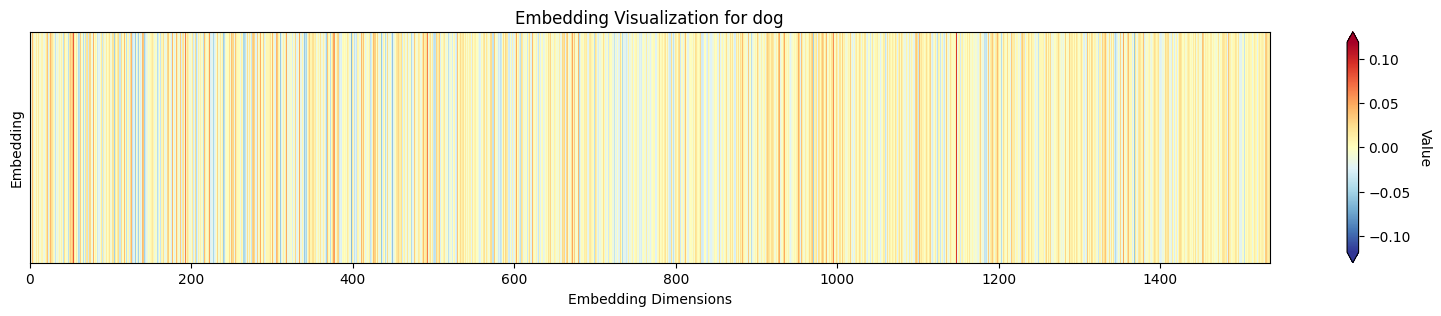

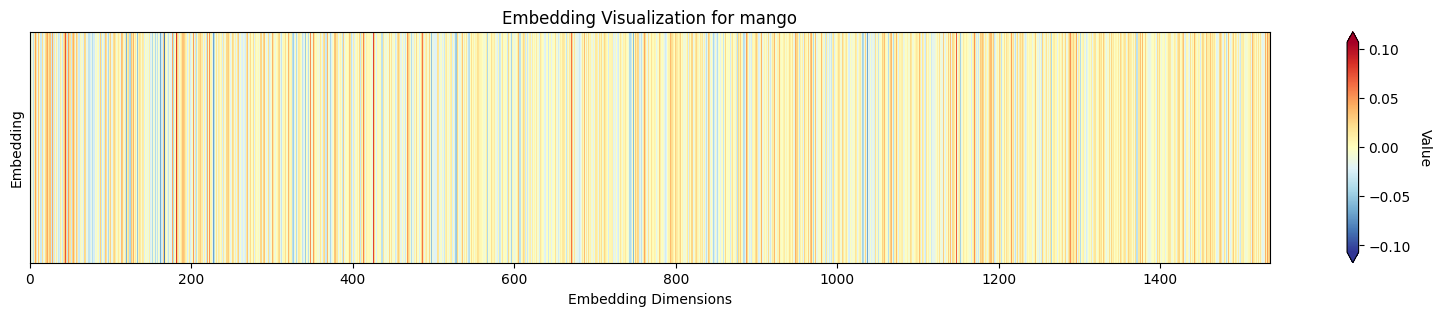

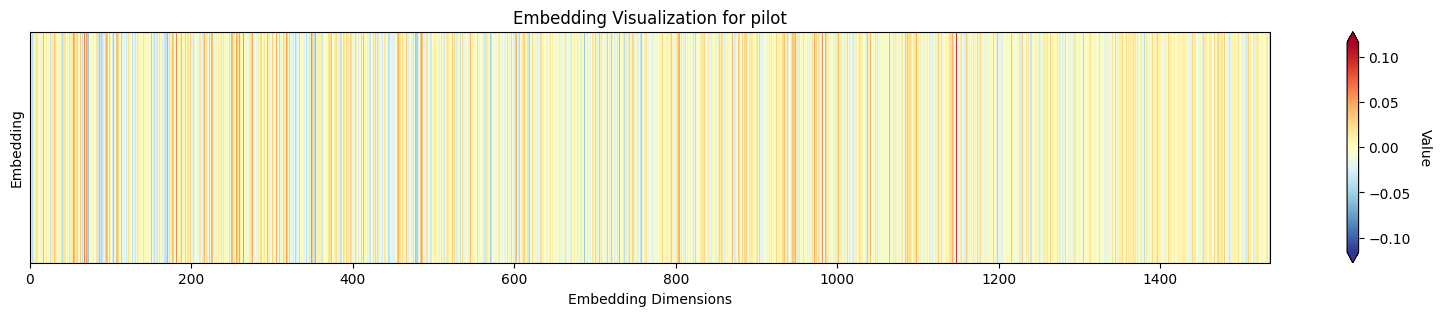

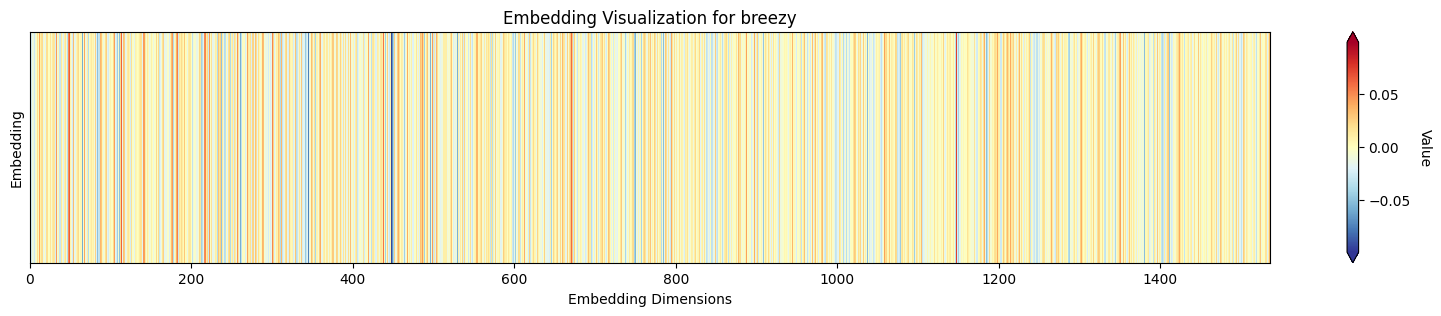

In [6]:
def visualize_embedding(embedding, title="Embedding Visualization"):
    # Reshape the embedding to a 2D array
    embedding_2d = np.array(embedding).reshape(1, -1)
    
    # Create a diverging colormap centered at zero
    cmap = plt.cm.RdYlBu_r
    vmax = max(abs(np.min(embedding_2d)), abs(np.max(embedding_2d)))
    norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=(20, 3))
    im = ax.imshow(embedding_2d, aspect='auto', cmap=cmap, norm=norm)
    
    # Set title and labels
    plt.title(title)
    plt.xlabel("Embedding Dimensions")
    plt.ylabel("Embedding")
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, extend='both')
    cbar.set_label('Value', rotation=270, labelpad=15)
    
    # Remove y-axis ticks
    ax.set_yticks([])
    
    # Show every 200th tick on x-axis
    ax.set_xticks(range(0, len(embedding), 200))
    ax.set_xticklabels(range(0, len(embedding), 200))

    plt.show()

visualize_embedding(get_embedding("dog", df), "Embedding Visualization for dog")
visualize_embedding(get_embedding("mango", df), "Embedding Visualization for mango")
visualize_embedding(get_embedding("pilot", df), "Embedding Visualization for pilot")
visualize_embedding(get_embedding("breezy", df), "Embedding Visualization for breezy")

This visualization shows the value of all 1536 dimensions in the word embedding as a color scale

### 2D Representation

With 1536-dimensional embeddings, it's impossible to directly visualize the data, so introducing the t-distributed Stochastic Neighbor Embedding model to help! t-SNE is a machine learning algorithm used for dimensionality reduction that will help us reduce this to 2D or 3D, allowing us to plot and observe patterns, clusters, or relationships in our embedding space. It is designed to preserve the relationships between data points while reducing dimensionality. 

While we won't capture all the nuanced details of our high dimension space, we can see some general trends!

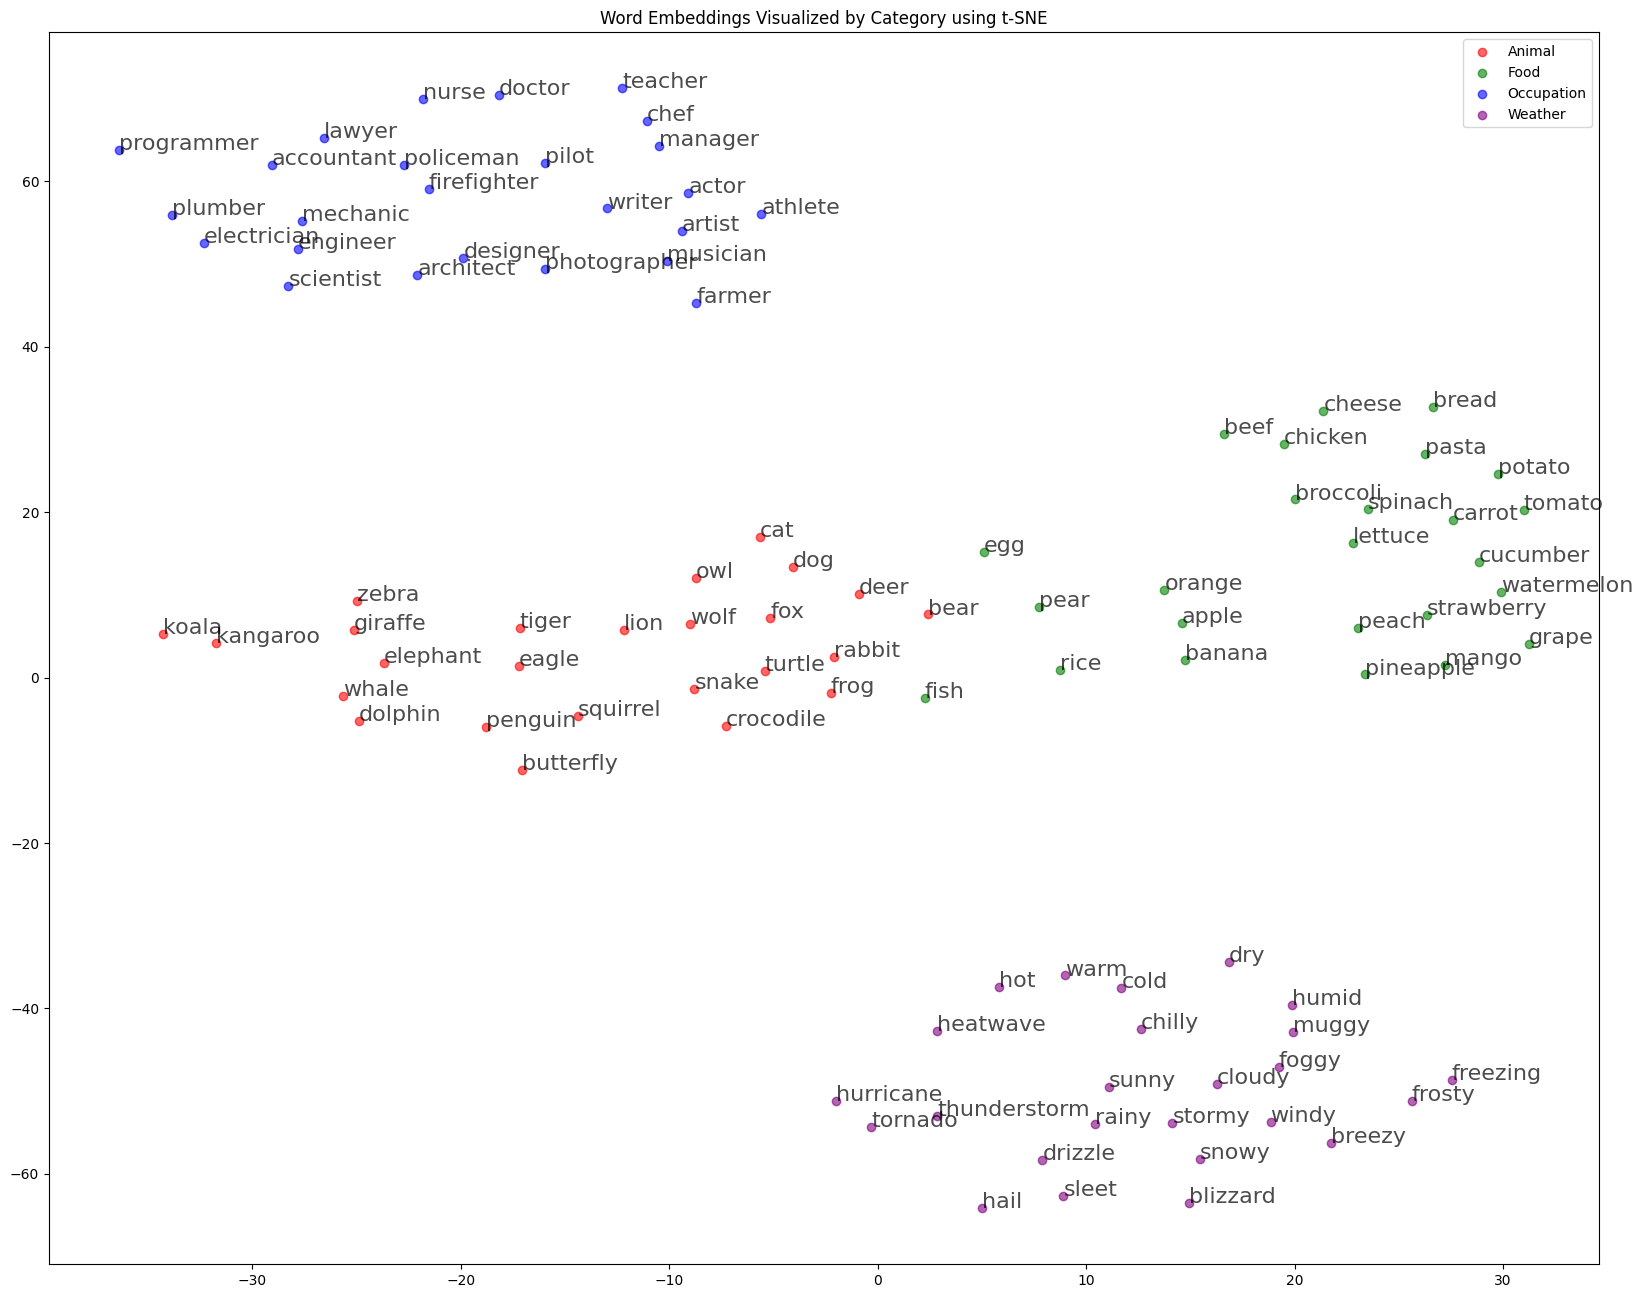

In [7]:
# Convert string representations of lists to numpy arrays
matrix = np.array(df['embedding'].apply(eval).tolist())

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=2, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)

# Define colors for each category
category_colors = {
    'Animal': 'red',
    'Food': 'green',
    'Occupation': 'blue',
    'Weather': 'purple'
}

# Create the scatter plot
plt.figure(figsize=(20, 16))  # Increased figure size for better visibility
for category, color in category_colors.items():
    category_mask = df['Category'] == category
    category_data = vis_dims[category_mask]
    words = df['Word'][category_mask]
    
    plt.scatter(category_data[:, 0], category_data[:, 1], c=color, label=category, alpha=0.6)
    
    # Add labels to each point
    for i, word in enumerate(words):
        plt.annotate(word, (category_data[i, 0], category_data[i, 1]), fontsize=16, alpha=0.7)

plt.title("Word Embeddings Visualized by Category using t-SNE")
plt.legend()
plt.show()

### 3D Representation

In [8]:
# Convert string representations of lists to numpy arrays
matrix = np.array(df['embedding'].apply(eval).tolist())

# Create a t-SNE model and transform the data
tsne = TSNE(
    n_components=3,
    perplexity=10,
    n_iter=5000,
    learning_rate='auto',
    init='pca',
    random_state=2
)
vis_dims = tsne.fit_transform(matrix)

category_colors = {
    'Animal': 'red',
    'Food': 'green',
    'Occupation': 'blue',
    'Weather': 'purple'
}

# Create traces for each category
traces = []
for category, color in category_colors.items():
    category_mask = df['Category'] == category
    category_data = vis_dims[category_mask]
    words = df['Word'][category_mask]
    
    # Create hover text with only coordinates
    hovertext = [f"X: {x:.2f}, Y: {y:.2f}, Z: {z:.2f}" 
                 for x, y, z in category_data]
    
    trace = go.Scatter3d(
        x=category_data[:, 0],
        y=category_data[:, 1],
        z=category_data[:, 2],
        mode='markers+text',
        name=category,
        marker=dict(
            size=5,
            color=color,
            opacity=0.7
        ),
        text=words,
        textposition="top center",
        hovertext=hovertext,
        hoverinfo='text',
        textfont=dict(size=12)
    )
    traces.append(trace)

# Create the layout
layout = go.Layout(
    title="Word Embeddings Visualized by Category using t-SNE (3D)",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='cube',
        camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=1.5, y=1.5, z=1.5)
        ),
    ),
    width=1000,  
    height=800,
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(
        x=0.9,
        y=0.9,
        traceorder="normal",
        font=dict(size=12),
        bgcolor="rgba(255, 255, 255, 0.5)"
    ),
    hovermode='closest'
)

# Create the figure and display
fig = go.Figure(data=traces, layout=layout)
init_notebook_mode(connected=True)
fig.show()

*Note: This 3D graph doesn't render on github*

---

# Calculating Similarity

<img src="https://images.contentstack.io/v3/assets/bltac01ee6daa3a1e14/bltbfd3d7e3452e01c7/65de3a8c6e7edb400cb4f753/img_blog_image2_inline.png?width=1120&disable=upscale&auto=webp" width=600>

Comparing vector embeddings and determining their similarity is crucial for semantic retrieval. The choice of similarity metric can significantly impact the accuracy of your search results. A key principle is to align the similarity metric of your index with the one used in training your embedding model. For instance, if you're using the [all-MiniLM-L6-v2 model](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2#fine-tuning), which was trained using cosine similarity, employing the same metric in your index will yield the most accurate results.

The concept of "closeness" between vectors is central to understanding semantic relationships. In the context of word embeddings, two vectors may be considered "close" if they represent words used in similar contexts or related to similar ideas. This notion of similarity forms the foundation for the following calculations and their applications in semantic search systems.

Here are a couple popular methods for dense vector NLP settings:

### Euclidean/L2 Distance

Measures the straight-line distance between two vectors in a vector space. It ranges from 0 to infinity, where 0 represents identical vectors, and larger values represent increasingly dissimilar vectors.

   $\text{Euclidean distance} = \|\mathbf{A} - \mathbf{B}\| = \sqrt{\sum_{i=1}^n (A_i - B_i)^2}$

   Where $\mathbf{A}$ and $\mathbf{B}$ are vectors, and $A_i$ and $B_i$ are their respective components.

**Euclidean Distance in two Dimensions**

<img src="https://www.pinecone.io/_next/image/?url=https%3A%2F%2Fcdn.sanity.io%2Fimages%2Fvr8gru94%2Fproduction%2Ffc175963bced347c4984d95d021cbe423d6154db-416x429.png&w=1080&q=75" width=300>

Commonly applied to embeddings when the magnitude of the vectors is meaningful. It measures the straight-line distance between two embedding vectors in the high-dimensional space. In the context of embeddings, a smaller Euclidean distance indicates greater similarity, making it useful for tasks like finding nearest neighbors or clustering similar items.

In [9]:
def euclidean_distance(vec1, vec2):
    """Calculate Euclidean distance between two vectors."""
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(vec1, vec2)))

print("Hot & Cold: ", euclidean_distance(get_embedding("hot", df), get_embedding("cold", df)))
print("Hot & Programmer: ", euclidean_distance(get_embedding("hot", df), get_embedding("programmer", df)))

Hot & Cold:  0.9440164141889588
Hot & Programmer:  1.2950602664127295


### Dot Product:

Measures the product of the magnitudes of two vectors and the cosine of the angle between them. It ranges from -∞ to ∞, where a positive value represents vectors that point in the same direction, 0 represents orthogonal vectors, and a negative value represents vectors that point in opposite directions.

$\mathbf{A} \cdot \mathbf{B} = \sum_{i=1}^n A_i B_i = A_1B_1 + A_2B_2 + \cdots + A_nB_n$

Where $\mathbf{A}$ and $\mathbf{B}$ are vectors, and $A_i$ and $B_i$ are their respective components.

**Dot Product in Two Dimensions**

<img src="https://www.pinecone.io/_next/image/?url=https%3A%2F%2Fcdn.sanity.io%2Fimages%2Fvr8gru94%2Fproduction%2Fb2af046e6a6d5d2057f2328171d0bdeba0489a90-338x357.png&w=750&q=75" width=300>

Less commonly used alone for comparing embeddings, the dot product is a fundamental operation in many similarity calculations. For embeddings, it provides a measure of how aligned two vectors are, with higher values indicating greater similarity. It's particularly useful when working with normalized embeddings, as it then effectively captures the cosine similarity. (As seen with OpenAI embeddings, which are normalized)

In [10]:
def dot_product(vec1, vec2):
    """Calculate dot product of two vectors."""
    return sum(a * b for a, b in zip(vec1, vec2))

print("Hot & Cold: ", dot_product(get_embedding("hot", df), get_embedding("cold", df)))
print("Hot & Programmer: ", dot_product(get_embedding("hot", df), get_embedding("programmer", df)))

Hot & Cold:  0.5544164660964531
Hot & Programmer:  0.16140940629592512


### Cosine Similarity:

Measures the cosine of the angle between two vectors in a vector space. It ranges from -1 to 1, where 1 represents identical vectors, 0 represents orthogonal vectors, and -1 represents vectors that are diametrically opposed.

   $\text{cosine similarity} = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|} = \frac{\sum_{i=1}^n A_i B_i}{\sqrt{\sum_{i=1}^n A_i^2} \sqrt{\sum_{i=1}^n B_i^2}}$

   Where $\mathbf{A}$ and $\mathbf{B}$ are vectors, and $A_i$ and $B_i$ are their respective components.

**Cosine Similarity in Two Dimensions**

<img src="https://www.pinecone.io/_next/image/?url=https%3A%2F%2Fcdn.sanity.io%2Fimages%2Fvr8gru94%2Fproduction%2F5a5ba7e0971f7b6dc4697732fa8adc59a46b6d8d-338x357.png&w=750&q=75" width=300>

Widely used for comparing embeddings, especially in natural language processing and information retrieval. It measures the cosine of the angle between two embedding vectors, focusing on their orientation rather than magnitude. This makes it particularly useful for comparing embeddings of different lengths or when the relative direction of vectors is more important than their absolute values.

In [11]:
def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors."""
    dot_prod = sum(a * b for a, b in zip(vec1, vec2))
    mag1 = math.sqrt(sum(a ** 2 for a in vec1))
    mag2 = math.sqrt(sum(b ** 2 for b in vec2))
    return dot_prod / (mag1 * mag2) if mag1 * mag2 != 0 else 0

print("Hot & Cold: ", cosine_similarity(get_embedding("hot", df), get_embedding("cold", df)))
print("Hot & Programmer: ", cosine_similarity(get_embedding("hot", df), get_embedding("programmer", df)))

Hot & Cold:  0.5544164875936521
Hot & Programmer:  0.16140941386337487


### Comparing All At Once

In [12]:
def compare_words(word1, word2, df):
    """Compare two words using their embeddings."""
    try:
        embedding1 = get_embedding(word1, df)
        embedding2 = get_embedding(word2, df)
        
        euc_dist = euclidean_distance(embedding1, embedding2)
        cos_sim = cosine_similarity(embedding1, embedding2)
        dot_prod = dot_product(embedding1, embedding2)
        
        print(f"Comparison between '{word1}' and '{word2}':")
        print(f"Euclidean Distance: {euc_dist:.4f}")
        print(f"Cosine Similarity: {cos_sim:.4f}")
        print(f"Dot Product: {dot_prod:.4f}")
        print()
    except ValueError as e:
        print(f"Error: {e}")

compare_words("hot", "cold", df)
compare_words("hot", "warm", df)

Comparison between 'hot' and 'cold':
Euclidean Distance: 0.9440
Cosine Similarity: 0.5544
Dot Product: 0.5544

Comparison between 'hot' and 'warm':
Euclidean Distance: 0.8565
Cosine Similarity: 0.6332
Dot Product: 0.6332



---
# Semantic Retrieval

<img src="https://raw.githubusercontent.com/UKPLab/sentence-transformers/master/docs/img/SemanticSearch.png" width=350>

This leads us to one of the most powerful applications - semantic search and retrieval.

Instead of the traditional key-query based database, we can use these similarity calculation methods to retrieve *similar* entries 

In [13]:
df2 = pd.read_csv('/Users/alucek/Documents/Jupyter_Notebooks/embeddings-guide/new_embeddings.csv')

# Concatenate the DataFrames
df_combined = pd.concat([df, df2], ignore_index=True)
df_combined

,Word,Category,embedding
0,dog,Animal,"[0.05113774910569191, -0.01870863139629364, -0..."
1,cat,Animal,"[0.025529420003294945, -0.023411665111780167, ..."
2,elephant,Animal,"[0.0468301959335804, -0.036735061556100845, -0..."
3,lion,Animal,"[0.03309255465865135, -0.06823775172233582, 0...."
4,tiger,Animal,"[-0.022506916895508766, -0.044839587062597275,..."
...,...,...,...
99,muggy,Weather,"[-0.0029042107053101063, 0.006667866837233305,..."
100,parakeet,Animal,"[0.05223187059164047, -0.014343400485813618, -..."
101,cabbage,Food,"[0.03496464341878891, 0.0027530803345143795, 0..."
102,therapist,Occupation,"[-0.011547889560461044, 0.0051359753124415874,..."


In [14]:
compare_words("parakeet", "cat", df_combined)
compare_words("therapist", "mechanic", df_combined)
compare_words("cabbage", "orange", df_combined)
compare_words("drought", "thunderstorm", df_combined)

Comparison between 'parakeet' and 'cat':
Euclidean Distance: 1.1374
Cosine Similarity: 0.3531
Dot Product: 0.3531

Comparison between 'therapist' and 'mechanic':
Euclidean Distance: 1.1238
Cosine Similarity: 0.3686
Dot Product: 0.3686

Comparison between 'cabbage' and 'orange':
Euclidean Distance: 1.2075
Cosine Similarity: 0.2710
Dot Product: 0.2710

Comparison between 'drought' and 'thunderstorm':
Euclidean Distance: 1.0938
Cosine Similarity: 0.4018
Dot Product: 0.4018



In [15]:
import ast

def get_top_5_similar(query_word, df_queries, df_combined):
    # Get the query embedding
    query_embedding = ast.literal_eval(df_queries[df_queries['Word'] == query_word]['embedding'].iloc[0])
    
    # Convert embeddings to numpy arrays and calculate cosine similarities
    similarities = []
    for emb_str in df_combined['embedding']:
        emb = np.array(ast.literal_eval(emb_str))
        query_emb = np.array(query_embedding)
        similarity = cosine_similarity(query_emb, emb)
        similarities.append(similarity)
    
    # Get indices of top 5 similar entries
    top_5_indices = np.argsort(similarities)[-5:][::-1]
    
    # Print results
    print(f"Top 5 similar entries for '{query_word}':")
    for idx in top_5_indices:
        word = df_combined.iloc[idx]['Word']
        category = df_combined.iloc[idx]['Category']
        similarity = similarities[idx]
        print(f"Word: {word}, Category: {category}, Similarity: {similarity:.4f}")

get_top_5_similar("cabbage", df2, df)
print("-----")
get_top_5_similar("drought", df2, df)
print("-----")
get_top_5_similar("parakeet", df2, df)
print("-----")
get_top_5_similar("therapist", df2, df)
print("-----")

Top 5 similar entries for 'cabbage':
Word: cucumber, Category: Food, Similarity: 0.5925
Word: lettuce, Category: Food, Similarity: 0.5860
Word: carrot, Category: Food, Similarity: 0.5534
Word: broccoli, Category: Food, Similarity: 0.5157
Word: potato, Category: Food, Similarity: 0.4648
-----
Top 5 similar entries for 'drought':
Word: dry, Category: Weather, Similarity: 0.4736
Word: drizzle, Category: Weather, Similarity: 0.4561
Word: rainy, Category: Weather, Similarity: 0.4327
Word: heatwave, Category: Weather, Similarity: 0.4161
Word: thunderstorm, Category: Weather, Similarity: 0.4018
-----
Top 5 similar entries for 'parakeet':
Word: penguin, Category: Animal, Similarity: 0.5124
Word: squirrel, Category: Animal, Similarity: 0.4386
Word: butterfly, Category: Animal, Similarity: 0.4362
Word: kangaroo, Category: Animal, Similarity: 0.4289
Word: pear, Category: Food, Similarity: 0.4054
-----
Top 5 similar entries for 'therapist':
Word: doctor, Category: Occupation, Similarity: 0.4646
Wo

---
# Vector Indexxing & Searching Algorithms

<img src="https://rockset.com/images/knn/image1.png" width=400>

Obviously its very inneficient and costly to run calculations over everything every time you want to compare a new embedding to your existing embeddings. This is where vector databases come in to set up specific indexxing and querying optimized for similarity comparisons.

To do this they use Approximate Nearest Neighbor (ANN) algorithms- efficient techniques for finding similar items in large datasets. ANN algorithms trade perfect accuracy for significantly improved speed, making them ideal for high-dimensional data and large-scale applications. These algorithms use various approaches to quickly narrow down the search space, allowing for fast similarity queries in vector databases.

Here are a few ways that Vector DBs approach indexxing embeddings:

### K-Dimensional Trees

<img src="https://groups.csail.mit.edu/graphics/classes/6.838/S98/meetings/m13/kd.gif" width=600>

#### Basic Concept

KD-Trees (K-Dimensional Trees) are binary trees where each node represents a point in k-dimensional space. The tree recursively partitions the space along alternating dimensions, creating a hierarchical structure that allows for faster searching in multidimensional data.

#### Indexing

1. **Tree Construction**:
   - Begin with the complete set of points.
   - Choose a dimension and find the median point along that dimension.
   - Use this median point to split the space into two subspaces.
   - Recursively apply this process to each subspace, cycling through dimensions.

2. **Insertion**:
   - Start at the root node.
   - Compare the new point's coordinates with the current node's splitting dimension.
   - Traverse left or right based on this comparison.
   - Continue until reaching a leaf node, where the new point is inserted.

#### Similarity Search

1. **Nearest Neighbor Search**:
   - Begin at the root and traverse the tree as if inserting the query point.
   - Keep track of the closest point found so far.
   - Use distance calculations to determine if other branches need to be explored.

2. **Backtracking**:
   - After reaching a leaf, backtrack up the tree.
   - At each level, check if the other branch could contain a closer point.
   - Explore promising branches based on distance calculations.

3. **Performance Considerations**:
   - Search efficiency decreases as dimensionality increases (curse of dimensionality).
   - In low to moderate dimensions, KD-Trees offer logarithmic time complexity for queries.
   - For high-dimensional data, performance may degrade to linear time in worst cases.

### Locality Sensitive Hashing (LSH)

<img src="https://www.pinecone.io/_next/image/?url=https%3A%2F%2Fcdn.sanity.io%2Fimages%2Fvr8gru94%2Fproduction%2F606382d0ca90a8d24f26780f5f9954123e37be91-575x603.png&w=1200&q=75" width=600>

#### Basic Concept

Locality-Sensitive Hashing uses hash functions that map similar items to the same hash value with higher probability than dissimilar items. Unlike traditional hash functions that aim to minimize collisions, LSH intentionally causes collisions for similar items.

#### Indexing

1. **Hash Function Selection**:
   - Choose a family of hash functions that are locality-sensitive for the distance measure in use (e.g., Euclidean distance, cosine similarity).
   - Common LSH families include:
     - Random Projections for cosine similarity
     - p-stable distributions for Lp distances

2. **Hash Table Construction**:
   - Create multiple hash tables, each using a different combination of hash functions.
   - For each vector in the dataset:
     - Compute its hash value using the hash functions for each table.
     - Store the vector in the corresponding bucket in each hash table.

#### Similarity Search

1. **Query Processing**:
   - Hash the query vector using the same hash functions used for indexing.
   - Retrieve vectors from the buckets that match the query's hash values.

2. **Candidate Set Generation**:
   - Combine the vectors retrieved from all hash tables into a candidate set.
   - Remove duplicates from the candidate set.

3. **Distance Computation**:
   - Compute actual distances between the query vector and vectors in the candidate set.
   - Return the k nearest neighbors based on these computed distances.

#### Performance Considerations

- **Efficiency**: LSH can achieve sublinear query time in high-dimensional spaces.
- **Accuracy vs. Speed**: Adjusting the number of hash tables and hash functions allows trade-offs between query speed and result accuracy.
- **Dimensionality**: LSH performs well in high-dimensional spaces where tree-based methods often struggle.
- **Memory Usage**: Multiple hash tables can consume significant memory, especially for large datasets.

### Product Quantization (PQ)

<img src="https://www.pinecone.io/_next/image/?url=https%3A%2F%2Fcdn.sanity.io%2Fimages%2Fvr8gru94%2Fproduction%2F791910350d7d2140dbe684b405ef5ee761c8fc6a-1060x720.png&w=3840&q=75" width=600>

#### Basic Concept

PQ decomposes high-dimensional vectors into multiple lower-dimensional subvectors. Each subvector is then quantized using a smaller codebook, effectively compressing the original vector. This allows for compact storage and fast distance computations.

#### Indexing

1. **Vector Decomposition**:
   - Divide each d-dimensional vector into m subvectors of d/m dimensions each.

2. **Codebook Generation**:
   - For each of the m subspaces:
     - Apply k-means clustering to the subvectors in that subspace.
     - The resulting k cluster centroids form the codebook for that subspace.

3. **Vector Encoding**:
   - For each original vector:
     - Replace each subvector with the index of its nearest centroid in the corresponding codebook.
     - Store the resulting sequence of m indices (typically bytes) instead of the full vector.

#### Similarity Search

1. **Query Preparation**:
   - Decompose the query vector into m subvectors.

2. **Distance Table Computation**:
   - For each subspace, compute distances between the query subvector and all centroids in the codebook.
   - Store these distances in lookup tables.

3. **Approximate Distance Calculation**:
   - For each database vector:
     - Sum the precomputed distances for each subvector using the lookup tables.
     - This sum approximates the distance between the query and the database vector.

4. **Candidate Selection**:
   - Return the vectors with the smallest approximate distances as the nearest neighbors.

#### Performance Considerations

- **Compression**: PQ significantly reduces memory usage, allowing larger datasets to fit in memory.
- **Search Speed**: Distance calculations are performed on compressed representations, greatly accelerating search.
- **Accuracy vs. Compression**: Increasing m (number of subspaces) improves compression but may reduce accuracy. Increasing k (codebook size) improves accuracy but increases memory usage.
- **Dimensionality**: PQ handles high-dimensional data well, making it suitable for modern embedding vectors.
- **Adaptability**: Can be combined with other techniques (e.g., Inverted File Index) for further performance improvements.

### Inverted File Index (IVF)

<img src="https://miro.medium.com/v2/resize:fit:1286/1*o6tLFAPCY5kZWIGOLOn8gw.png" width=600>

#### Basic Concept

IVF divides the vector space into a number of clusters, each represented by a centroid. Vectors are assigned to their nearest centroid, and an inverted index maps each centroid to its member vectors. This structure allows for efficient pruning of the search space during queries.

#### Indexing

1. **Cluster Generation**:
   - Apply k-means clustering to a sample of the dataset to generate a set of centroids.
   - The number of centroids (k) is typically much smaller than the total number of vectors.

2. **Vector Assignment**:
   - For each vector in the dataset:
     - Find the nearest centroid.
     - Assign the vector to this centroid's cluster.

3. **Inverted Index Construction**:
   - Create a data structure that maps each centroid to the list of vectors assigned to it.

#### Similarity Search

1. **Query Processing**:
   - Find the nearest centroids to the query vector.
   - Typically, multiple (e.g., nprobe) nearest centroids are considered.

2. **Candidate Set Generation**:
   - Retrieve the vectors assigned to the selected centroids using the inverted index.
   - These vectors form the candidate set for detailed distance computation.

3. **Refinement**:
   - Compute actual distances between the query vector and the candidates.
   - Return the k nearest vectors based on these computed distances.

#### Performance Considerations

- **Search Efficiency**: By limiting detailed distance computations to a subset of the data, IVF significantly speeds up search in large datasets.
- **Accuracy vs. Speed Trade-off**: Adjusting the number of clusters (k) and the number of probed clusters (nprobe) allows for balancing between search speed and result accuracy.
- **Memory Usage**: IVF typically requires less additional memory compared to some other indexing structures, as it mainly stores cluster assignments.
- **Scalability**: Well-suited for large-scale datasets, as search complexity grows sublinearly with dataset size.
- **Combination with Other Techniques**: Often combined with compression methods like Product Quantization (IVF-PQ) for further efficiency gains.

### Hierarchichal Navigable Small World (HNSW)

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*ziU6_KIDqfmaDXKA1cMa8w.png" width=600>

#### Basic Concept

HNSW builds a multilayered graph where each layer is a "navigable small world" - a graph with both short-range and long-range connections. The top layer is sparsely connected, with density increasing in lower layers. This structure allows for efficient logarithmic-complexity searches.

#### Indexing

1. **Multilayer Graph Construction**:
   - For each vector:
     - Randomly assign it to a maximum layer level based on an exponential distribution.
     - Insert the vector into all layers from its maximum level down to the bottom layer.

2. **Node Insertion (per layer)**:
   - Use the layer above (if exists) as an entry point.
   - Perform a greedy search to find M nearest neighbors in the current layer.
   - Connect the new node bidirectionally to these neighbors, maintaining a maximum of M connections per node.

3. **Graph Optimization**:
   - Periodically or during insertion, optimize connections to ensure a good balance of short and long-range links.

#### Similarity Search

1. **Entry Point Selection**:
   - Start at the entry point of the top layer.

2. **Greedy Search**:
   - At each layer, perform a greedy search to find the nearest neighbor to the query.
   - Use this neighbor as the entry point for the next lower layer.

3. **Beam Search in Bottom Layer**:
   - In the bottom (densest) layer, perform a beam search.
   - Maintain a dynamic list of best candidates, expanding the search to their neighbors.

4. **Result Refinement**:
   - Return the k nearest neighbors found during the beam search.

#### Performance Considerations

- **Search Complexity**: Achieves logarithmic time complexity for search operations, making it extremely fast even for large datasets.
- **Accuracy**: Provides high accuracy, often comparable to exact search methods.
- **Memory Usage**: Requires more memory than some other ANN algorithms due to storing the graph structure.
- **Incremental Updates**: Supports efficient insertion of new items without rebuilding the entire index.
- **Scalability**: Excellent performance on both CPU and GPU, making it suitable for various hardware setups.
- **Tuning**: Parameters like the number of connections per node (M) and the size of the dynamic candidate list during search can be tuned to balance between search speed and accuracy.

---
# Vector Database and RAG Setup

<img src="https://miro.medium.com/v2/resize:fit:1400/0*kPXvR_-LxPfdsojc.png" width=600>

Let's put it all together into a retrieval augmented generation flow:
1. Chunking text
2. Creating a Vector Database
3. Indexxing the text chunks
4. Setting up an LLM
5. Connecting retrieval with LLM for RAG

In [16]:
# RAG Dependencies
import os
import chromadb
from langchain_openai import ChatOpenAI
from IPython.display import display, Markdown
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Chunking the Text

We'll be using the [TIES-Merging: Resolving Interference When Merging Models](https://arxiv.org/abs/2306.01708#) paper for our example, along with LangChain integrations with PDF loaders and chunkers.

In [17]:
loader = PyPDFLoader("/Users/alucek/Documents/Jupyter_Notebooks/embeddings-guide/ties_merging.pdf")
pages = loader.load()

document = ""
for i in range(len(pages)):
    document += pages[i].page_content

We'll be using a recursive token based chunking system, following [OpenAI's File Search tool parameters](https://platform.openai.com/docs/assistants/tools/file-search/how-it-works)

In [18]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    model_name="gpt-4",
    chunk_size=800,
    chunk_overlap=400,
)

chunks = text_splitter.split_text(document)

In [19]:
print(len(chunks), "\n")
print(chunks[0][:500])

62 

TIES-MERGING : Resolving Interference When
Merging Models
Prateek Yadav1Derek Tam1
Leshem Choshen2,3Colin Raffel1Mohit Bansal1
1University of North Carolina at Chapel Hill2IBM Research3MIT
leshem.choshen@ibm.com
{praty,dtredsox,craffel,mbansal}@cs.unc.edu
Abstract
Transfer learning – i.e., further fine-tuning a pre-trained model on a downstream
task – can confer significant advantages, including improved downstream perfor-
mance, faster convergence, and better sample efficiency. These advantages


### Indexxing into ChromaDB

For our vector database of choice, we'll be using [ChromaDB](https://www.trychroma.com/), an open source and lightweight vector database. By default they index vectors using Hierarchical Navigable Small World.

In [20]:
path = "/Users/alucek/Documents/Jupyter_Notebooks/embeddings-guide/chromadb"
client = chromadb.PersistentClient(path=path)

In [21]:
ties_collection = client.get_or_create_collection(name='ties_collection', metadata={"hnsw:space": "cosine"})

In [22]:
i = 0
for chunk in chunks:
    ties_collection.add(
    documents=[chunk],
    ids=[f"chunk_{i}"]
    )
    i += 1

In [23]:
ties_collection.count()

62

In [24]:
query = "What is the process for electing signs?"

results = ties_collection.query(
    query_texts=[query],
    n_results=5)

In [25]:
for i in range(3):
    print("-------\n")
    print("Retrieved Doc: ", i+1)
    print("Chunk: ", results['ids'][0][i])
    print("Distance: ", results['distances'][0][i])
    print("Text Snippet: ", f"{results['documents'][0][i][:500]}...")
    

-------

Retrieved Doc:  1
Chunk:  chunk_22
Distance:  0.6302816389013587
Text Snippet:  (see#in Fig. 2). In the Appendix B.5, we bring a more detailed view, including a comparison to
applying TIES-MERGING and show reducing interference encourages diversity in specific parameter
values (std) together with the similarity of their influence (mean).
(b) Importance of Resolving Sign Interference. To quantify the impact of sign interference,
we group the parameters by their sign agreement . A value of 0.5indicates an equal number of
positive and negative signs for a given parameter acros...
-------

Retrieved Doc:  2
Chunk:  chunk_10
Distance:  0.7073322213708346
Text Snippet:  sign vector γt∈Rdand a magnitude vector µt∈Rdasτt=γt⊙µt, where ⊙is the elementwise
product. Formally, γt=sgn(τt), where sgn(x)∗ |x|=xand returns a value of +1,0, or−1. The
magnitude vector µtis defined as µt=|τt|and the value µi
ttells us the movement required in the
i-th dimension from the initialization.
4.2 Steps 

### LLM & Prompt Setup

Now that we have the vector database setup, the second half is setting up our LLM to be able to take in the retrieved documents and the user query to provide a retrieval augemented generation response.

We'll be using LangChain with GPT-4o to set this dynamic prompt up. 

In [26]:
rag_prompt_template = """
You are a data science AI assistant. 
Respond to the user question below using the provided contextual documents retrieved from a research paper.

Context Documents: {documents}

User Question: {question}

"""

rag_prompt = ChatPromptTemplate.from_template(rag_prompt_template)
llm = ChatOpenAI(temperature=0.0, model="gpt-4o")

rag_chain = rag_prompt | llm | StrOutputParser()

### Full RAG Pipeline

Now we put it together to take the user's question, retrieve relevant documents from the vector database with it, and pass the question + context to the LLM to generate a response

In [28]:
def rag_query(query):
    results = ties_collection.query(query_texts=[query], n_results=5)
    documents = results['documents'][0]
    response = rag_chain.invoke({"question": query, "documents": documents})
    return response

In [29]:
output = rag_query("How does sign election happen at that step of the process?")

display(Markdown(output))

In the TIES-MERGING process, the sign election step is crucial for resolving disagreements in the sign of each parameter across different models. Here’s a detailed explanation of how sign election happens:

1. **Aggregate Elected Sign Vector Creation**:
   - For each parameter \( p \) in the task vectors, the method first separates the values based on their sign (positive or negative).
   - The total magnitude (or mass) of the positive and negative values is then calculated. This is done by summing the magnitudes of the values that have positive signs and those that have negative signs separately.

2. **Choosing the Dominant Sign**:
   - The sign with the highest total magnitude is chosen as the elected sign for that parameter. This means if the sum of the magnitudes of the positive values is greater than the sum of the magnitudes of the negative values, the elected sign will be positive, and vice versa.

3. **Efficient Computation**:
   - This process can be efficiently computed using the formula:
     \[
     \gamma_p^m = \text{sgn}\left(\sum_{t=1}^{n} \hat{\tau}_p^t\right)
     \]
     where \( \gamma_p^m \) is the elected sign for parameter \( p \), and \( \hat{\tau}_p^t \) represents the value of parameter \( p \) in the task vector \( \hat{\tau}_t \) for model \( t \).

By following these steps, the TIES-MERGING method ensures that the elected sign for each parameter is the one that has the greatest overall influence across all the models being merged. This helps in reducing sign interference and maintaining the integrity of the parameter values during the merging process.

---
# Other Use Cases for Embeddings

<img src="https://miro.medium.com/v2/resize:fit:1400/1*svydqyHkUxl3tbP5eADecg.png" width=450>

1. **Clustering:**
Embeddings can be used to group similar documents, sentences, or words together in high-dimensional space. This is particularly useful for organizing large collections of text data, such as categorizing news articles or grouping customer feedback. Clustering can reveal hidden patterns or themes within the data that may not be immediately apparent.

<img src="https://miro.medium.com/v2/resize:fit:1078/1*byMr5hdnA4S5WCsQodZ39Q.png" width=450>

2. **Recommendations:**
By comparing the embeddings of items a user has interacted with to other items in a database, recommendation systems can suggest similar content. This technique is widely used in e-commerce to recommend products, in content platforms to suggest articles or videos, and in music streaming services to create personalized playlists.

<img src="https://pub.mdpi-res.com/electronics/electronics-13-02625/article_deploy/html/images/electronics-13-02625-g001.png?1722331959" width=450>

3. **Anomaly detection:**
Embeddings can help identify unusual or anomalous data points that don't fit well with the rest of the dataset. This is valuable in various fields, such as fraud detection in financial transactions, identifying unusual network traffic for cybersecurity, or detecting manufacturing defects in quality control processes.

<img src="https://dl.acm.org/cms/attachment/html/10.1145/3411764.3445782/assets/html/images/image38.png" width=450>

4. **Diversity measurement:**
By examining the distribution of embeddings in a dataset, one can assess the diversity of the content. This can be useful in content curation to ensure a wide range of perspectives, in team formation to balance skill sets, or in academic research to evaluate the breadth of a literature review.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*XjDmui7Zprb809NsMNBV4Q.png" width=450>

5. **Classification:**
Embeddings can be used to classify content into predefined categories by comparing the embedding of a new piece of content to the embeddings of known categories. This approach is often more flexible than traditional classification methods, especially when dealing with new or ambiguous examples, and can be particularly effective for multi-label classification tasks.